In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
with zipfile.ZipFile('../data/data-tx.csv.zip') as z:
    with z.open('data-tx.csv') as f:
        transfers = pd.read_csv(f,parse_dates=['createdAt'])

In [3]:
transfers.head()

,id,total,customerId,createdAt
0,29261,50000.0,5de2ffee6bad5850e5d3a0e3,2019-12-01 00:00:26.899000+00:00
1,29262,50000.0,5d76f219cc8ccc0047caba8c,2019-12-01 00:04:47.894000+00:00
2,29263,50000.0,5de304f06bad5850e5d3a269,2019-12-01 00:11:39.676000+00:00
3,29264,31000.0,5dd1628b3bea4b0060742232,2019-12-01 00:13:25.523000+00:00
4,29265,30000.0,5dd0adca3bea4b0060741da7,2019-12-01 00:13:57.747000+00:00


# 1. Feature Engineering

## Features_1: days of the week one hot enconding

In [4]:
transfers1 = transfers.copy()
transfers1['date'] = transfers1['createdAt'].dt.date
transfers1['dayOfWeek'] = transfers1['createdAt'].dt.dayofweek
feat1 = transfers1.groupby('date').agg({'dayOfWeek':np.min})
feat1 = feat1.rename(columns={'amin':'dayOfWeek'})

In [5]:
feat1 = pd.get_dummies(data=feat1['dayOfWeek'],prefix='weekday',drop_first=False)
feat1.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,
2019-12-01,0,0,0,0,0,0,1
2019-12-02,1,0,0,0,0,0,0
2019-12-03,0,1,0,0,0,0,0
2019-12-04,0,0,1,0,0,0,0
2019-12-05,0,0,0,1,0,0,0


## Features_2: rolling average of transferred amounts (last 2 days) + rolling standard deviation of transferred amounts (last 6 days)

### Features_2.1: rolling standard deviation of transferred amounts (last 6 days)

In [6]:
feat2_1 = transfers1.groupby('date').agg({'total':[np.sum]})
feat2_1 = feat2_1.rename(columns={'sum':'amount_lag_0d'})
feat2_1.columns = feat2_1.columns.droplevel(0)
feat2_1['amount_lag_0d'] = feat2_1['amount_lag_0d']/1000
feat2_1['amount_std_rolling_6d'] = feat2_1['amount_lag_0d'].rolling(6).aggregate(np.std)
feat2_1 = feat2_1.drop('amount_lag_0d',axis=1)

### Features_2.2: rolling average of transferred amounts (last 2 days)

In [7]:
feat2_2 = transfers1.groupby('date').agg({'total':[np.sum]})
feat2_2 = feat2_2.rename(columns={'sum':'amount_lag_0d'})
feat2_2.columns = feat2_2.columns.droplevel(0)
feat2_2['amount_lag_0d'] = feat2_2['amount_lag_0d']/1000
feat2_2['amount_mean_rolling_2d'] = feat2_2['amount_lag_0d'].rolling(2).aggregate(np.mean)
feat2_2 = feat2_2.drop('amount_lag_0d',axis=1)

### Features_2

In [8]:
feat2 = pd.merge(feat2_1,feat2_2,how='outer',left_index=True,right_index=True)
feat2.head(10)

,amount_std_rolling_6d,amount_mean_rolling_2d
date,,
2019-12-01,NaN,NaN
2019-12-02,NaN,18702.194072
2019-12-03,NaN,27984.815992
2019-12-04,NaN,24087.363913
2019-12-05,NaN,20722.281953
2019-12-06,6519.533732,22286.086844
2019-12-07,4713.034212,21539.547223
2019-12-08,7130.404663,16350.751186
2019-12-09,5668.660724,17367.032292


In [9]:
feat2.tail(10)

,amount_std_rolling_6d,amount_mean_rolling_2d
date,,
2020-09-24,12571.339174,41210.509992
2020-09-25,13776.277011,50777.342991
2020-09-26,7201.937856,49238.795538
2020-09-27,13070.920873,30474.933383
2020-09-28,14315.191005,38138.339893
2020-09-29,14142.932011,53085.393151
2020-09-30,15413.828790,54094.631366
2020-10-01,17169.977962,63240.409386
2020-10-02,17837.310305,65645.006779


## Features_3: top 0.5% of customers' transfers per day using lag N=0,1,2,...,8 (we use volume of transfers NOT amount)   

In [10]:
top05pct_clients = transfers.groupby('customerId').agg('count')['total'].sort_values(ascending=False).head(int(len(transfers['customerId'].unique())*0.005)).index
top05pct_clients

Index(['5e1bb63ca7f353007914155f', '5e7a6d46d252e432e500df0f',
       '5e19e338580d530056bdcd03', '5e233730797b000052a4ddfe',
       '5e2b4d67bf3b7a00603e48d9', '5e1dbad384eafd006e548fb7',
       '5e16620175009c0075159dd1', '5dc1eeced1e6c6006ae20439',
       '5dab94851519d7007a5c4851', '5e090989c031c4007ff8a058',
       ...
       '5e82a91c8c622b16d8fa95e9', '5dc5f99beb2f6b0056b6f286',
       '5d263be0fa2dd0003d964bda', '5da8e8052487ea2632036084',
       '5e1751dd834df70067c055d6', '5de3f1b86ec8e500801460a2',
       '5c76c9e686648e001ed7e2da', '5e9e27de5fba8100767e88e7',
       '5e62671424c4740064e1b3dd', '5c8442e07bbab8002131436f'],
      dtype='object', name='customerId', length=128)

In [11]:
feat3 = transfers1.groupby(['date','customerId']).agg(['count'])[['total']].reset_index()
feat3 = feat3.rename(columns={'total':'volume'})
feat3.columns = feat3.columns.get_level_values(0)

In [12]:
dates = pd.date_range(start='2019-12-01', end='2020-10-03').to_list()
print(min(dates))
print(max(dates))

2019-12-01 00:00:00
2020-10-03 00:00:00


In [13]:
dates = pd.DataFrame({'date':dates})
dates['date'] = dates['date'].dt.date
dates.head()

,date
0,2019-12-01
1,2019-12-02
2,2019-12-03
3,2019-12-04
4,2019-12-05


In [14]:
top05 = pd.DataFrame({'customerId':top05pct_clients})
top05.head()

,customerId
0,5e1bb63ca7f353007914155f
1,5e7a6d46d252e432e500df0f
2,5e19e338580d530056bdcd03
3,5e233730797b000052a4ddfe
4,5e2b4d67bf3b7a00603e48d9


In [15]:
dates_list = []
top05_list = []
for i in range(len(dates)):
    for j in range(len(top05)):
        dates_list.append(dates.loc[i,'date'])
        top05_list.append(top05.loc[j,'customerId'])

In [16]:
print(len(dates_list))
print(len(top05_list))

39424
39424


In [17]:
date_cust = pd.DataFrame({'date':dates_list,'customerId':top05_list})
date_cust.head()

,date,customerId
0,2019-12-01,5e1bb63ca7f353007914155f
1,2019-12-01,5e7a6d46d252e432e500df0f
2,2019-12-01,5e19e338580d530056bdcd03
3,2019-12-01,5e233730797b000052a4ddfe
4,2019-12-01,5e2b4d67bf3b7a00603e48d9


In [18]:
feat3 = pd.merge(date_cust,feat3,how='outer',on=['date','customerId'])
feat3 = feat3.fillna(0)
feat3.head()

,date,customerId,volume
0,2019-12-01,5e1bb63ca7f353007914155f,0.0
1,2019-12-01,5e7a6d46d252e432e500df0f,0.0
2,2019-12-01,5e19e338580d530056bdcd03,0.0
3,2019-12-01,5e233730797b000052a4ddfe,0.0
4,2019-12-01,5e2b4d67bf3b7a00603e48d9,0.0


In [19]:
df_clts = []
for clts in top05pct_clients:
    df_clts.append(pd.DataFrame(feat3[feat3['customerId']==clts]).reset_index(drop=True))

In [20]:
for i in range(len(df_clts)):
    df_clts[i]['volume_lag_1d'] = df_clts[i]['volume'].shift(1)
    df_clts[i]['volume_lag_2d'] = df_clts[i]['volume'].shift(2)
    df_clts[i]['volume_lag_3d'] = df_clts[i]['volume'].shift(3)
    df_clts[i]['volume_lag_4d'] = df_clts[i]['volume'].shift(4)
    df_clts[i]['volume_lag_5d'] = df_clts[i]['volume'].shift(5)
    df_clts[i]['volume_lag_6d'] = df_clts[i]['volume'].shift(6)
    df_clts[i]['volume_lag_7d'] = df_clts[i]['volume'].shift(7)
    df_clts[i]['volume_lag_8d'] = df_clts[i]['volume'].shift(8)

In [21]:
for i in range(len(df_clts)):
    df_clts[i] = df_clts[i].rename(columns={
        'volume':'{}_volume_lag_0d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_1d':'{}_volume_lag_1d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_2d':'{}_volume_lag_2d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_3d':'{}_volume_lag_3d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_4d':'{}_volume_lag_4d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_5d':'{}_volume_lag_5d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_6d':'{}_volume_lag_6d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_7d':'{}_volume_lag_7d'.format(df_clts[i]['customerId'][0]),
        'volume_lag_8d':'{}_volume_lag_8d'.format(df_clts[i]['customerId'][0]),
    })
    df_clts[i] = df_clts[i].drop('customerId',axis=1)
    df_clts[i] = df_clts[i].set_index('date')
    

In [22]:
feat3 = pd.concat(df_clts,axis=1)
feat3.head()

,5e1bb63ca7f353007914155f_volume_lag_0d,5e1bb63ca7f353007914155f_volume_lag_1d,5e1bb63ca7f353007914155f_volume_lag_2d,5e1bb63ca7f353007914155f_volume_lag_3d,5e1bb63ca7f353007914155f_volume_lag_4d,5e1bb63ca7f353007914155f_volume_lag_5d,5e1bb63ca7f353007914155f_volume_lag_6d,5e1bb63ca7f353007914155f_volume_lag_7d,5e1bb63ca7f353007914155f_volume_lag_8d,5e7a6d46d252e432e500df0f_volume_lag_0d,...,5e62671424c4740064e1b3dd_volume_lag_8d,5c8442e07bbab8002131436f_volume_lag_0d,5c8442e07bbab8002131436f_volume_lag_1d,5c8442e07bbab8002131436f_volume_lag_2d,5c8442e07bbab8002131436f_volume_lag_3d,5c8442e07bbab8002131436f_volume_lag_4d,5c8442e07bbab8002131436f_volume_lag_5d,5c8442e07bbab8002131436f_volume_lag_6d,5c8442e07bbab8002131436f_volume_lag_7d,5c8442e07bbab8002131436f_volume_lag_8d
date,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-02,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-04,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,0.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
2019-12-05,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,1.0,0.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN


## Labels

In [23]:
label = transfers1.groupby('date').agg({'total':[np.sum]})
label = label.rename(columns={'sum':'amount_lag_0d'})
label.columns = label.columns.droplevel(0)
label['amount_lag_0d'] = label['amount_lag_0d']/1000

In [24]:
label['label'] = label['amount_lag_0d'].shift(-1)
label = label.drop('amount_lag_0d',axis=1)
label.head()

,label
date,
2019-12-01,24926.824147
2019-12-02,31042.807836
2019-12-03,17131.919991
2019-12-04,24312.643915
2019-12-05,20259.529773


In [25]:
label.tail()

,label
date,
2020-09-29,59684.036956
2020-09-30,66796.781815
2020-10-01,64493.231743
2020-10-02,43960.753733
2020-10-03,NaN


# 2. Modelling

## Data prep: every model has to be trained and tested in the same range of dates in order to be comparable among them.

In [26]:
df1 = pd.merge(feat1,label,how='outer',left_index=True,right_index=True)
df1 = df1.iloc[8:-1,:]
print(df1.index[0])
print(df1.index[-1])
print('null values:',df1.isnull().sum().sum())
print(df1.shape)
df1.head()

2019-12-09
2020-10-02
null values: 0
(299, 8)


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,label
date,,,,,,,,
2019-12-09,1,0,0,0,0,0,0,21205.156654
2019-12-10,0,1,0,0,0,0,0,22373.128652
2019-12-11,0,0,1,0,0,0,0,17682.445821
2019-12-12,0,0,0,1,0,0,0,25249.037288
2019-12-13,0,0,0,0,1,0,0,21281.507021


In [27]:
df2 = pd.merge(feat2,label,how='outer',left_index=True,right_index=True)
df2 = df2.iloc[8:-1,:]
print(df2.index[0])
print(df2.index[-1])
print('null values:',df2.isnull().sum().sum())
print(df2.shape)
df2.head()

2019-12-09
2020-10-02
null values: 0
(299, 3)


,amount_std_rolling_6d,amount_mean_rolling_2d,label
date,,,
2019-12-09,5668.660724,17367.032292,21205.156654
2019-12-10,5516.116487,23028.641770,22373.128652
2019-12-11,5304.659775,21789.142653,17682.445821
2019-12-12,5405.352428,20027.787236,25249.037288
2019-12-13,5756.180307,21465.741554,21281.507021


In [28]:
df3 = pd.merge(feat3,label,how='outer',left_index=True,right_index=True)
df3 = df3.iloc[8:-1,:]
print(df3.index[0])
print(df3.index[-1])
print('null values:',df3.isnull().sum().sum())
print(df3.shape)
df3.head()

2019-12-09
2020-10-02
null values: 0
(299, 1153)


,5e1bb63ca7f353007914155f_volume_lag_0d,5e1bb63ca7f353007914155f_volume_lag_1d,5e1bb63ca7f353007914155f_volume_lag_2d,5e1bb63ca7f353007914155f_volume_lag_3d,5e1bb63ca7f353007914155f_volume_lag_4d,5e1bb63ca7f353007914155f_volume_lag_5d,5e1bb63ca7f353007914155f_volume_lag_6d,5e1bb63ca7f353007914155f_volume_lag_7d,5e1bb63ca7f353007914155f_volume_lag_8d,5e7a6d46d252e432e500df0f_volume_lag_0d,...,5c8442e07bbab8002131436f_volume_lag_0d,5c8442e07bbab8002131436f_volume_lag_1d,5c8442e07bbab8002131436f_volume_lag_2d,5c8442e07bbab8002131436f_volume_lag_3d,5c8442e07bbab8002131436f_volume_lag_4d,5c8442e07bbab8002131436f_volume_lag_5d,5c8442e07bbab8002131436f_volume_lag_6d,5c8442e07bbab8002131436f_volume_lag_7d,5c8442e07bbab8002131436f_volume_lag_8d,label
date,,,,,,,,,,,,,,,,,,,,,
2019-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,21205.156654
2019-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,22373.128652
2019-12-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,17682.445821
2019-12-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,25249.037288
2019-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,21281.507021


## Functions to automate training and testing

In [29]:
### we split the dataset in 8-day chunks
def data_chunks(dataframe):
    chunks = dict()
    for i in range(292): ### max number of complete chunks possible from the range of dates
        chunks[i] = dataframe.iloc[i:i+8,]
    return chunks

In [30]:
### we split each chunk in features and labels for training (7 days), and features and labels for testing (1 day)
def tr_tt_split(chunks):
    X_train = dict()
    X_test = dict()
    y_train = dict()
    y_test = dict()
    for i,ii in chunks.items():
        X_train[i] = chunks[i].iloc[:-1,:-1].values
        X_test[i] = chunks[i].iloc[-1:,:-1].values
        y_train[i] = chunks[i].iloc[:-1,-1].values
        y_test[i] = chunks[i].iloc[-1:,-1].values
    return X_train, X_test, y_train, y_test

In [31]:
### Root-mean-squared error of predictions vs real values
def rmse(X_train, X_test, y_train, y_test,model):
    RMSE_list = []
    y_preds = []
    RMSE_tr_list = []
    y_tr_preds = []
    for i in range(len(X_train)):
        model.fit(X_train[i],y_train[i])
        ### 
        y_pred_temp = model.predict(X_test[i])
        y_preds.append(y_pred_temp)
        RMSE_temp = np.sqrt(mean_squared_error(y_test[i],y_pred_temp))
        RMSE_list.append(RMSE_temp)
        ###
        y_tr_pred_temp = model.predict(X_train[i])
        y_tr_preds.append(y_tr_pred_temp)
        RMSE_tr_temp = np.sqrt(mean_squared_error(y_train[i],y_tr_pred_temp))
        RMSE_tr_list.append(RMSE_tr_temp)
        ###
    return RMSE_list, np.mean(RMSE_list),y_preds,RMSE_tr_list, np.mean(RMSE_tr_list),y_tr_preds

In [32]:
### R^2 of predictions vs real values
def r2(X_train, X_test, y_train, y_test,model):
    y_preds = []
    y_tr_preds = []
    r2_list = []
    r2_tr_list = []
    y_test_list = [item for sublist in y_test.values() for item in sublist]
    for i in range(len(X_train)):
        model.fit(X_train[i],y_train[i])
        ### 
        y_pred_temp = model.predict(X_test[i])
        y_preds.append(y_pred_temp)
    y_preds_list = [item for sublist in y_preds for item in sublist]
    R2 = r2_score(y_test_list,y_preds_list)
    return R2

In [33]:
### we plot the performance of the model
def metric_plots(chunks,RMSE_list):
    chunk_dates = []
    for i in range(len(chunks)):
        chunk_date_temp = chunks[i].index[-1]
        chunk_dates.append(chunk_date_temp)
    dates = chunk_dates
    #dates = [datetime.strptime(date, '%Y-%m-%d').date() for date in chunk_dates]
    fig, axs = plt.subplots(1,2,figsize=(14,7),dpi=100)
    axs[0].plot(dates,RMSE_tr_list,label="Train",c='navy')
    axs[0].plot(dates,RMSE_list,label="Test",c='r',alpha=0.2)
    axs[0].legend(loc='upper right')
    axs[0].tick_params('x',labelrotation=45)
    axs[0].annotate(text='RMSE train: {0:.0f}'.format(RMSE_tr), xy=(100,580),xycoords='figure pixels',c='navy')
    axs[0].annotate(text='RMSE test: {0:.0f}'.format(RMSE), xy=(100,565),xycoords='figure pixels',c='r')
    axs[0].set_title('RMSE')
    axs[0].set_ylabel('RMSE - 1000 COP')
    for i in range(len(y_preds_tr)):
        axs[1].scatter(y_preds_tr[i],y_train[i],alpha=0.1,c='navy')
        axs[1].scatter(y_preds[i],y_test[i],alpha=0.4,c='r')
    axs[1].plot([0,140000],[0,140000],c='black')
    axs[1].tick_params('x',labelrotation=45)
    y_preds_list_tr = [item for sublist in y_preds_tr for item in sublist]
    y_train_list = [item for sublist in y_train.values() for item in sublist]
    y_preds_list = [item for sublist in y_preds for item in sublist]
    y_test_list = [item for sublist in y_test.values() for item in sublist]
    r2_tr = r2_score(y_train_list,y_preds_list_tr)
    r2 = r2_score(y_test_list,y_preds_list)
    axs[1].annotate(text='R^2 train: {0:.1%}'.format(r2_tr), xy=(690,580),xycoords='figure pixels',c='navy')
    axs[1].annotate(text='R^2 test: {0:.1%}'.format(r2), xy=(690,565),xycoords='figure pixels',c='r')
    axs[1].set_title('R^2')
    axs[1].set_xlabel('Predicted values - 1000 COP')
    axs[1].set_ylabel('Real values - 1000 COP')
    plt.show()

## Training and testing of individual models

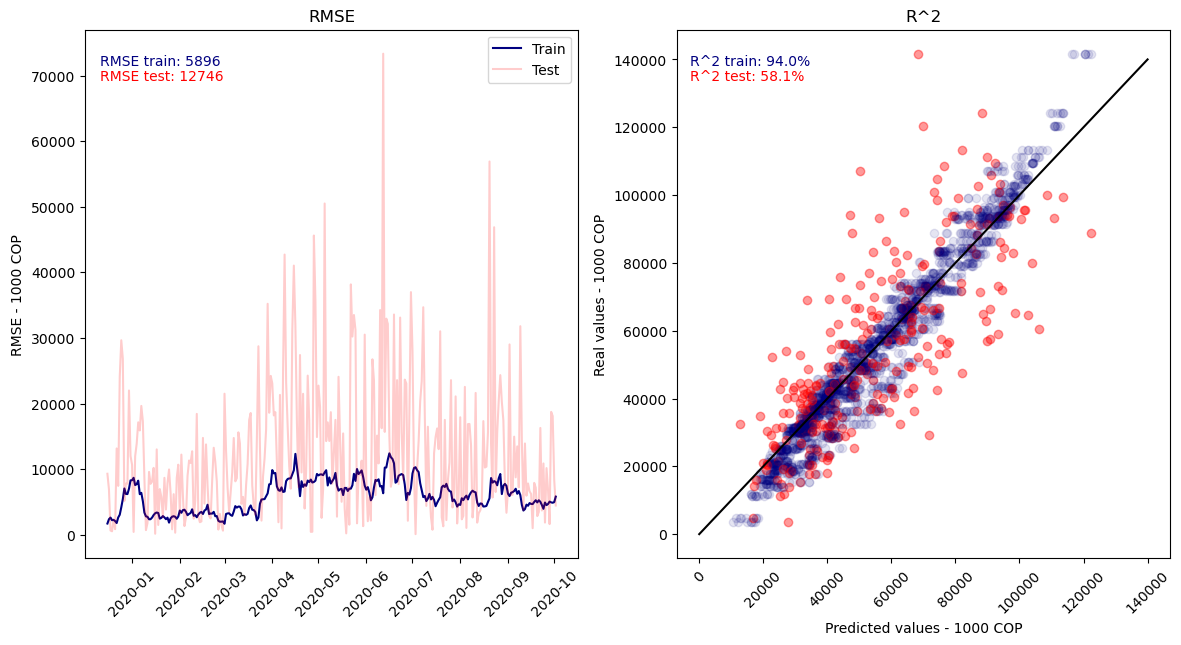

In [34]:
### Model 1 --> feat1
mod=RandomForestRegressor(n_estimators=250,
                     random_state=1)
chunks = data_chunks(df1)
X_train, X_test, y_train, y_test = tr_tt_split(chunks)
RMSE_list, RMSE, y_preds, RMSE_tr_list, RMSE_tr, y_preds_tr = rmse(X_train, X_test, y_train, y_test,model=mod)
y_preds1 = y_preds
RMSE1 = RMSE
metric_plots(chunks,RMSE_list)

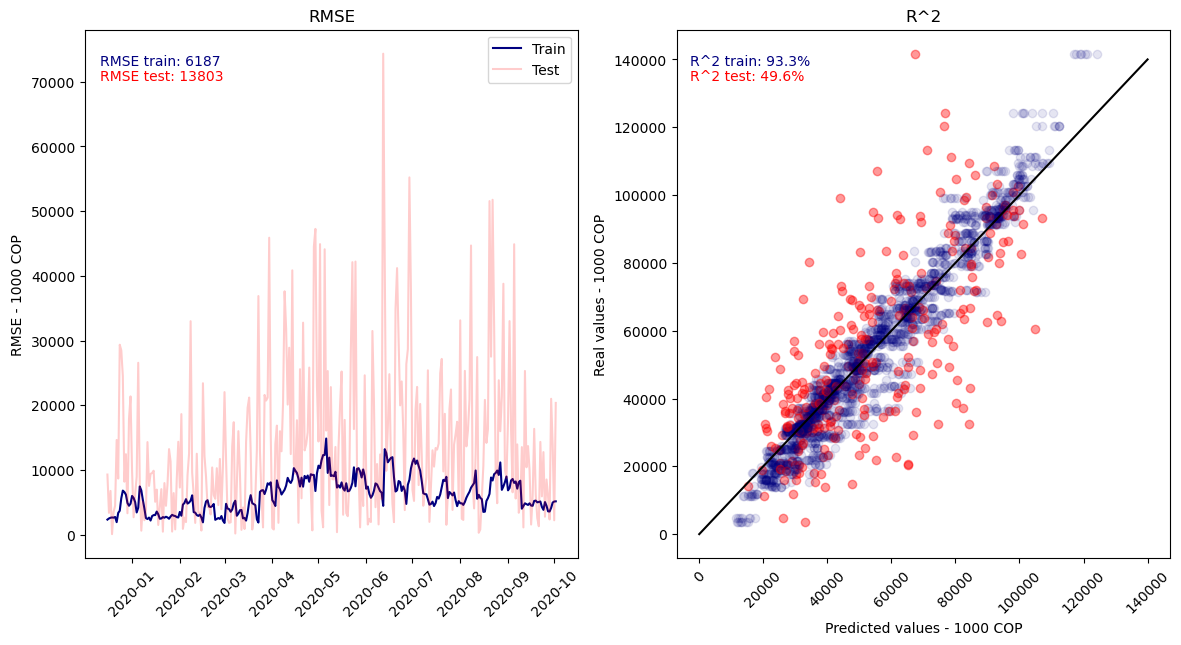

In [35]:
### Model 2 --> feat2
mod=RandomForestRegressor(n_estimators=300,
                     random_state=1)
chunks = data_chunks(df2)
X_train, X_test, y_train, y_test = tr_tt_split(chunks)
RMSE_list, RMSE, y_preds, RMSE_tr_list, RMSE_tr, y_preds_tr = rmse(X_train, X_test, y_train, y_test,model=mod)
y_preds2 = y_preds
RMSE2 = RMSE
metric_plots(chunks,RMSE_list)

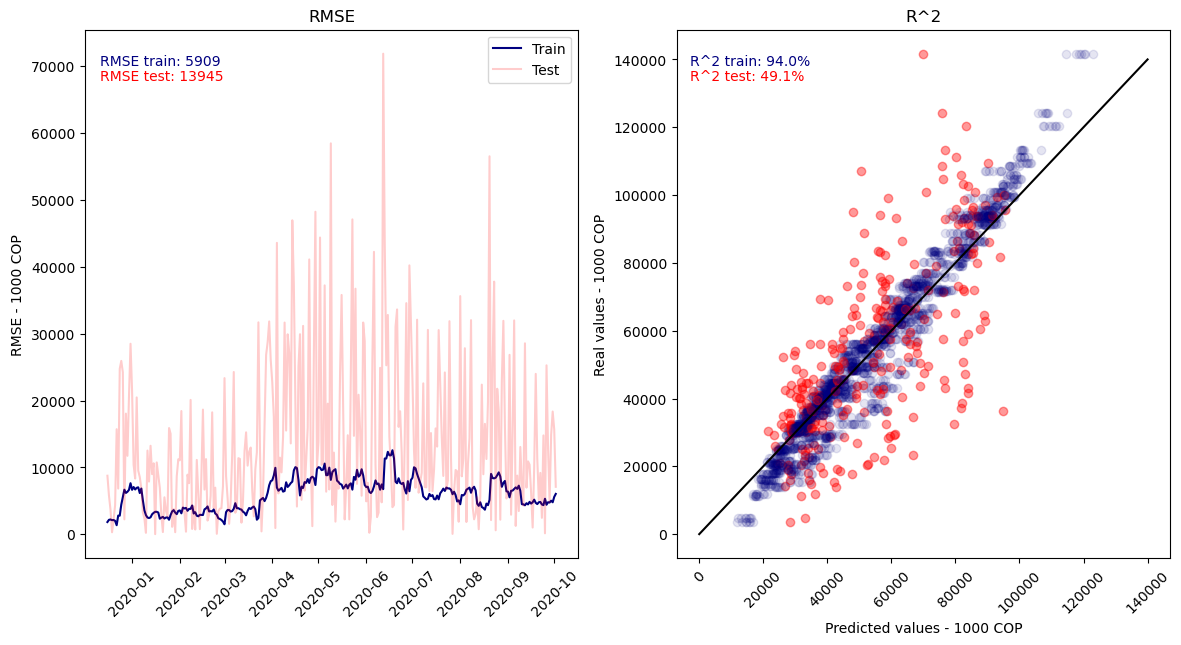

In [36]:
### Model 3 --> feat3
mod=RandomForestRegressor(n_estimators=400,
                     random_state=1)
chunks = data_chunks(df3)
X_train, X_test, y_train, y_test = tr_tt_split(chunks)
RMSE_list, RMSE, y_preds, RMSE_tr_list, RMSE_tr, y_preds_tr = rmse(X_train, X_test, y_train, y_test,model=mod)
y_preds3 = y_preds
RMSE3 = RMSE
metric_plots(chunks,RMSE_list)

# 3. Ensemble model

In [37]:
chunk_dates = []
for i in range(len(chunks)):
    chunk_date_temp = chunks[i].index[-1]
    chunk_dates.append(chunk_date_temp)
dates = chunk_dates
#dates = [datetime.strptime(date, '%Y-%m-%d').date() for date in chunk_dates]

In [38]:
y_preds1 = [item for sublist in y_preds1 for item in sublist]
y_preds2 = [item for sublist in y_preds2 for item in sublist]
y_preds3 = [item for sublist in y_preds3 for item in sublist]
y_test_list = [item for sublist in y_test.values() for item in sublist]

In [39]:
y_preds_ens = pd.DataFrame({'preds1':y_preds1,'preds2':y_preds2,'preds3':y_preds3,'y_test':y_test_list},index=dates)
y_preds_ens.head()

,preds1,preds2,preds3,y_test
2019-12-16,21047.458789,21057.750181,21587.604277,30344.263455
2019-12-17,22366.717647,25908.984222,23475.694253,29274.551909
2019-12-18,21213.596312,27326.757227,24237.841327,20569.173993
2019-12-19,25484.252707,25026.425942,24648.051223,24951.843826
2019-12-20,23616.871302,22428.090050,23719.586410,25935.751863


In [40]:
y_preds_ens['date'] = y_preds_ens.index
y_preds_ens['dayOfWeek'] = pd.to_datetime(y_preds_ens['date']).dt.dayofweek
y_preds_ens.head()

,preds1,preds2,preds3,y_test,date,dayOfWeek
2019-12-16,21047.458789,21057.750181,21587.604277,30344.263455,2019-12-16,0
2019-12-17,22366.717647,25908.984222,23475.694253,29274.551909,2019-12-17,1
2019-12-18,21213.596312,27326.757227,24237.841327,20569.173993,2019-12-18,2
2019-12-19,25484.252707,25026.425942,24648.051223,24951.843826,2019-12-19,3
2019-12-20,23616.871302,22428.090050,23719.586410,25935.751863,2019-12-20,4


In [41]:
### new predictions: if dayOfWeek=5: new_pred = pred_model1, 
###                  else: new_pred = (pred_model1 + pred_model2 + pred_model3)/3
y_preds_ens['preds_ens'] = np.where(y_preds_ens['dayOfWeek']==5,y_preds_ens['preds1'],(y_preds_ens['preds1']+
                                     y_preds_ens['preds2']+y_preds_ens['preds3'])/3)
y_preds_ens.head()

,preds1,preds2,preds3,y_test,date,dayOfWeek,preds_ens
2019-12-16,21047.458789,21057.750181,21587.604277,30344.263455,2019-12-16,0,21230.937749
2019-12-17,22366.717647,25908.984222,23475.694253,29274.551909,2019-12-17,1,23917.132041
2019-12-18,21213.596312,27326.757227,24237.841327,20569.173993,2019-12-18,2,24259.398289
2019-12-19,25484.252707,25026.425942,24648.051223,24951.843826,2019-12-19,3,25052.909957
2019-12-20,23616.871302,22428.090050,23719.586410,25935.751863,2019-12-20,4,23254.849254


## R^2 ensemble model

In [42]:
r2 = r2_score(y_preds_ens['y_test'],y_preds_ens['preds_ens'])
print('R^2 ensemble model:\t',r2)
r2 = r2_score(y_preds_ens['y_test'],y_preds_ens['preds1'])
print('R^2 model 1:\t\t\t',r2)
r2 = r2_score(y_preds_ens['y_test'],y_preds_ens['preds2'])
print('R^2 model 2:\t\t\t',r2)
r2 = r2_score(y_preds_ens['y_test'],y_preds_ens['preds3'])
print('R^2 model 3:\t\t\t',r2)

R^2 ensemble model:	 0.6501939675375961
R^2 model 1:			 0.5809033230387902
R^2 model 2:			 0.49561369357700447
R^2 model 3:			 0.4909833788730098


## RMSE ensemble model

In [43]:
y_preds_ens['RMSE'] = np.sqrt((y_preds_ens['y_test']-y_preds_ens['preds_ens'])**2)
y_preds_ens.head()

,preds1,preds2,preds3,y_test,date,dayOfWeek,preds_ens,RMSE
2019-12-16,21047.458789,21057.750181,21587.604277,30344.263455,2019-12-16,0,21230.937749,9113.325706
2019-12-17,22366.717647,25908.984222,23475.694253,29274.551909,2019-12-17,1,23917.132041,5357.419868
2019-12-18,21213.596312,27326.757227,24237.841327,20569.173993,2019-12-18,2,24259.398289,3690.224296
2019-12-19,25484.252707,25026.425942,24648.051223,24951.843826,2019-12-19,3,25052.909957,101.066131
2019-12-20,23616.871302,22428.090050,23719.586410,25935.751863,2019-12-20,4,23254.849254,2680.902609


In [44]:
df = y_preds_ens.copy()
df = df.reset_index()

In [45]:
RMSE_list = []
for i in range(len(df)):
    RMSE_temp = np.sqrt(mean_squared_error([df['y_test'][i]],[df['preds_ens'][i]]))
    RMSE_list.append(RMSE_temp)
df['RMSE'] = RMSE_list

In [46]:
print('RMSE ensemble model:\t',np.mean(df['RMSE']))
print('RMSE model 1:\t\t\t',RMSE1)
print('RMSE model 2:\t\t\t',RMSE2)
print('RMSE model 3:\t\t\t',RMSE3)

RMSE ensemble model:	 11346.260218321358
RMSE model 1:			 12746.15260122113
RMSE model 2:			 13803.34530043572
RMSE model 3:			 13944.888469005668


## Graphs

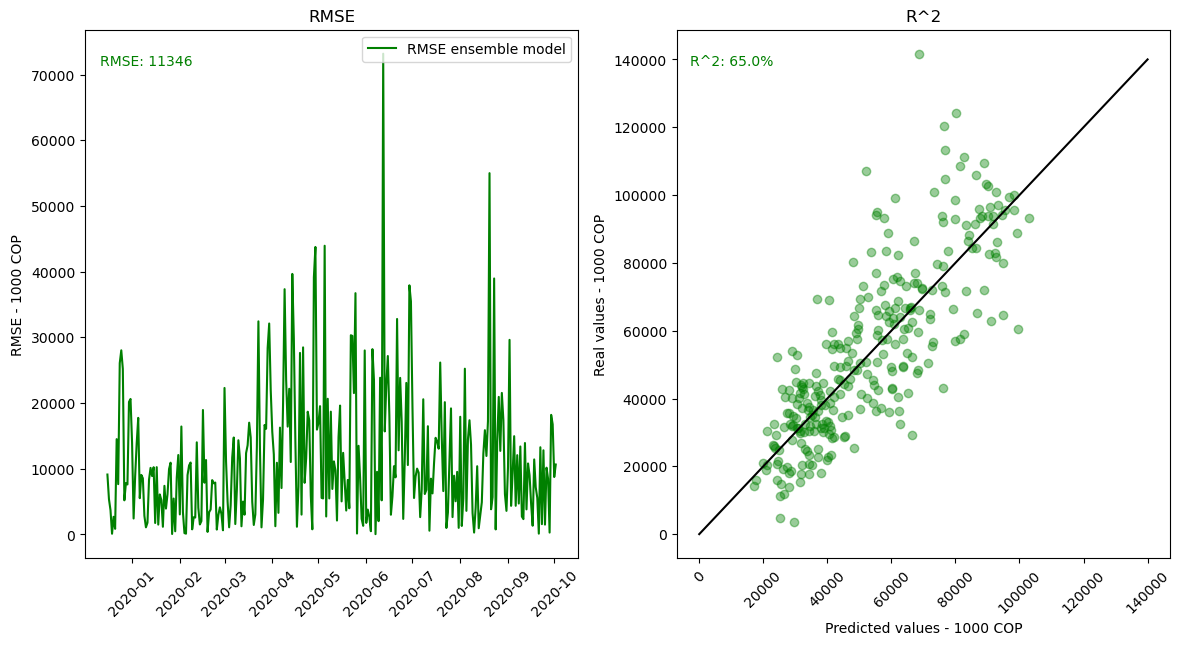

In [47]:
fig, axs = plt.subplots(1,2,figsize=(14,7),dpi=100)
axs[0].plot(y_preds_ens.index,df['RMSE'],label="RMSE ensemble model",c='g')
axs[0].legend(loc='upper right')
axs[0].tick_params('x',labelrotation=45)
axs[0].annotate(text='RMSE: {0:.0f}'.format(np.mean(y_preds_ens['RMSE'])),
                xy=(100,580),xycoords='figure pixels',c='g')
axs[0].set_title('RMSE')
axs[0].set_ylabel('RMSE - 1000 COP')
for i in range(len(y_preds_ens['preds_ens'])):
    axs[1].scatter(y_preds_ens['preds_ens'][i],y_test_list[i],alpha=0.4,c='g')
axs[1].plot([0,140000],[0,140000],c='black')
axs[1].tick_params('x',labelrotation=45)
axs[1].annotate(text='R^2: {0:.1%}'.format(r2_score(y_test_list,y_preds_ens['preds_ens'])),
                xy=(690,580),xycoords='figure pixels',c='g')
axs[1].set_title('R^2')
axs[1].set_xlabel('Predicted values - 1000 COP')
axs[1].set_ylabel('Real values - 1000 COP')
plt.show()

# 3-month predictions

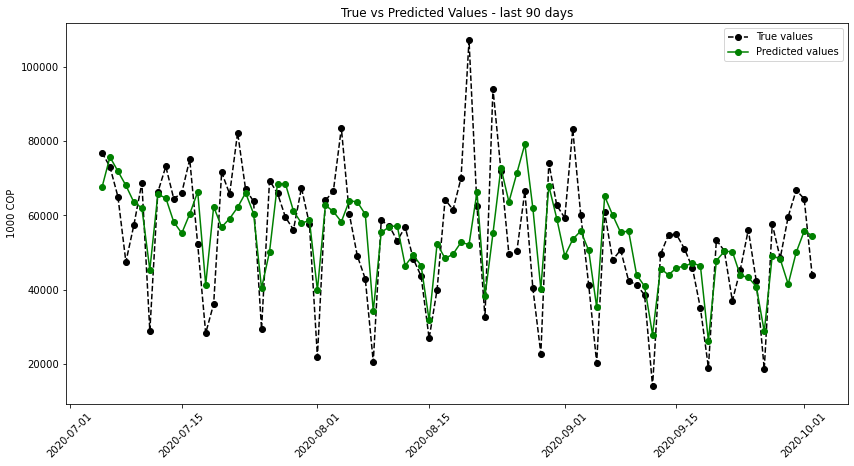

In [48]:
plt.figure(figsize=(14,7))
plt.plot(y_preds_ens[['y_test']].iloc[-90:,:],marker='o',linestyle='--',c='k',label='True values')
plt.plot(y_preds_ens[['preds_ens']].iloc[-90:,:],marker='o',c='g',label='Predicted values')
plt.title('True vs Predicted Values - last 90 days')
plt.xticks(rotation=45)
plt.ylabel('1000 COP')
plt.legend()
plt.show()

# 1-month predictions

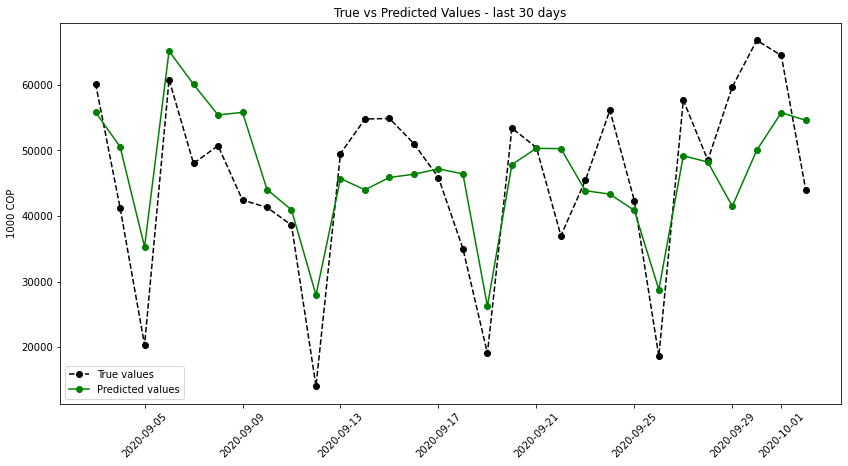

In [49]:
plt.figure(figsize=(14,7))
plt.plot(y_preds_ens[['y_test']].iloc[-30:,:],marker='o',linestyle='--',c='k',label='True values')
plt.plot(y_preds_ens[['preds_ens']].iloc[-30:,:],marker='o',c='g',label='Predicted values')
plt.title('True vs Predicted Values - last 30 days')
plt.xticks(rotation=45)
plt.ylabel('1000 COP')
plt.legend()
plt.show()

# 4. Optimization between minimize each prediction and meet the future demand

## Functions

In [50]:
### We adjust the predictions of the ensemble model by adding a percentage “p” to the prediction.
### The only argument of the function is the dataset y_preds_ens created before that contains the prediction of the ensemble model
### and the predictions of every model individually
def fun_list_results(y_preds_mod): 
    fact = np.linspace(0,1,101)   
    list_results = []
    for p in (fact):
        result_temp = np.where(y_preds_mod['dayOfWeek']==5,y_preds_mod['preds1'],(y_preds_mod['preds1']+
                                         y_preds_mod['preds2']+y_preds_mod['preds3'])/3 + p*((y_preds_mod['preds1']+
                                         y_preds_mod['preds2']+y_preds_mod['preds3'])/3))
        list_results.append(result_temp)
    return list_results

In [51]:
### We define a new metric that measures how well the new predictions are performing, considering we want to meet the
### demand of users and, at the same time, minimize all predictions.
### The arguments are the output of the previous function and a "penalization factor" that defines how much worse is to not meet
### the future demand compared to the objective of minimizing the predictions.
def fun_metric(list_results,penalization): 
    pen = penalization                      
    metric = []                             
    for i in range(len(list_results)):
        temp = np.where((pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[1]-
                     pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[0])>0,
                    (pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[1]-
                     pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[0])*(-pen),
                    (pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[1]-
                     pd.DataFrame(data=[list_results[i],y_preds_ens['y_test']]).transpose()[0]))
        metric.append(np.sum(temp))
    return metric, penalization

In [52]:
### We identify the best "p" that optimizes the new metric and adjust the predictions accordingly.
### The only argument of the function is the first output of the previous function.
def adj_preds(metric):
    fact = np.linspace(0,1,101)
    ind = np.argmax(metric)
    opt_fact = fact[ind]
    y_preds_adj = y_preds_ens.copy()
    y_preds_adj['adj_preds'] = np.where(y_preds_adj['dayOfWeek']==5,y_preds_adj['preds1'],((y_preds_adj['preds1']+
                                     y_preds_adj['preds2']+y_preds_adj['preds3'])/3) + 
                                   ((y_preds_adj['preds1']+y_preds_adj['preds2']+y_preds_adj['preds3'])/3)*opt_fact)
    return y_preds_adj

In [53]:
### We plot the results.
def plots(y_preds_adj,days,penalization):
    plt.figure(figsize=(20,10))
    plt.plot(y_preds_adj[['y_test']].iloc[-days:,:],marker='o',linestyle='--',c='k',label='True values')
    plt.plot(y_preds_adj[['adj_preds']].iloc[-days:,:],marker='o',c='g',label='Adjusted predictions')
    plt.title('True Values vs Adjusted Predictions - last {} days | penalization = {}'.format(days,penalization))
    plt.xticks(rotation=45)
    plt.ylabel('1000 COP')
    plt.legend()
    plt.show()

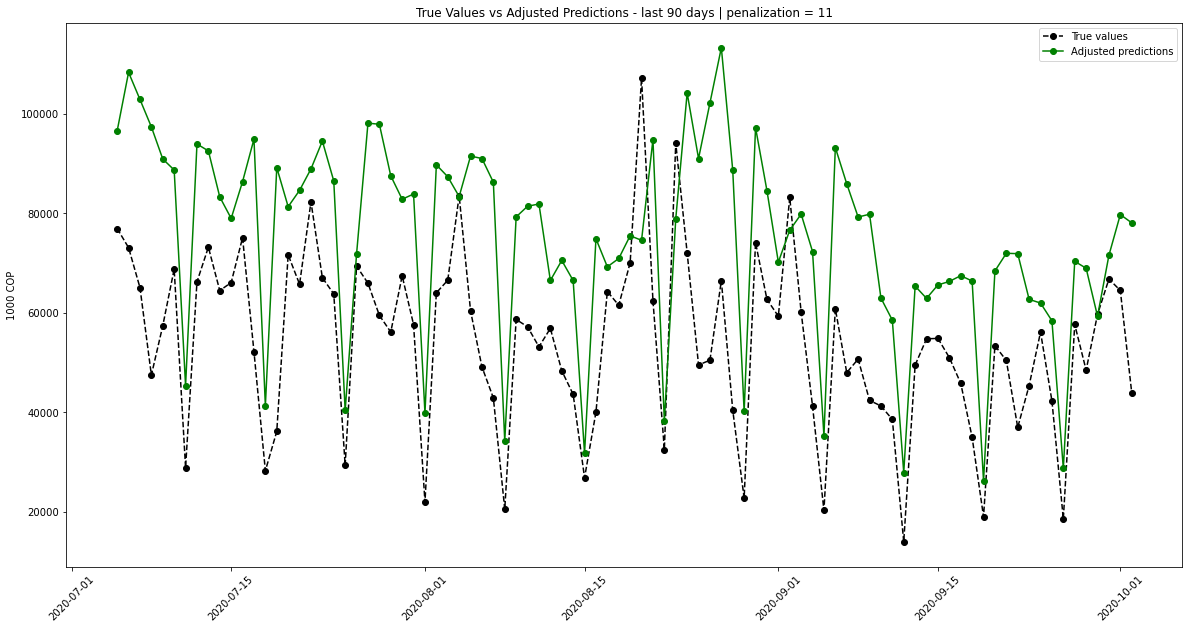

In [54]:
list_results = fun_list_results(y_preds_ens)
metric,penalization = fun_metric(list_results,penalization=11)
y_preds_adj = adj_preds(metric)
plots(y_preds_adj,90,penalization)

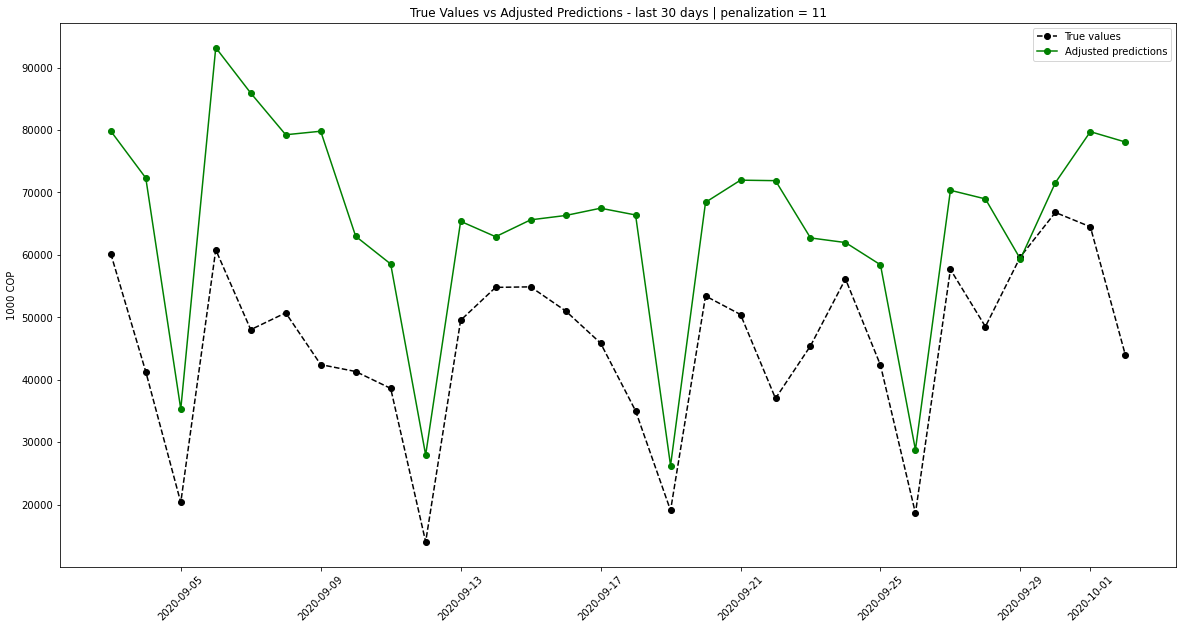

In [55]:
list_results = fun_list_results(y_preds_ens)
metric,penalization = fun_metric(list_results,penalization=11)
y_preds_adj = adj_preds(metric)
plots(y_preds_adj,30,penalization)

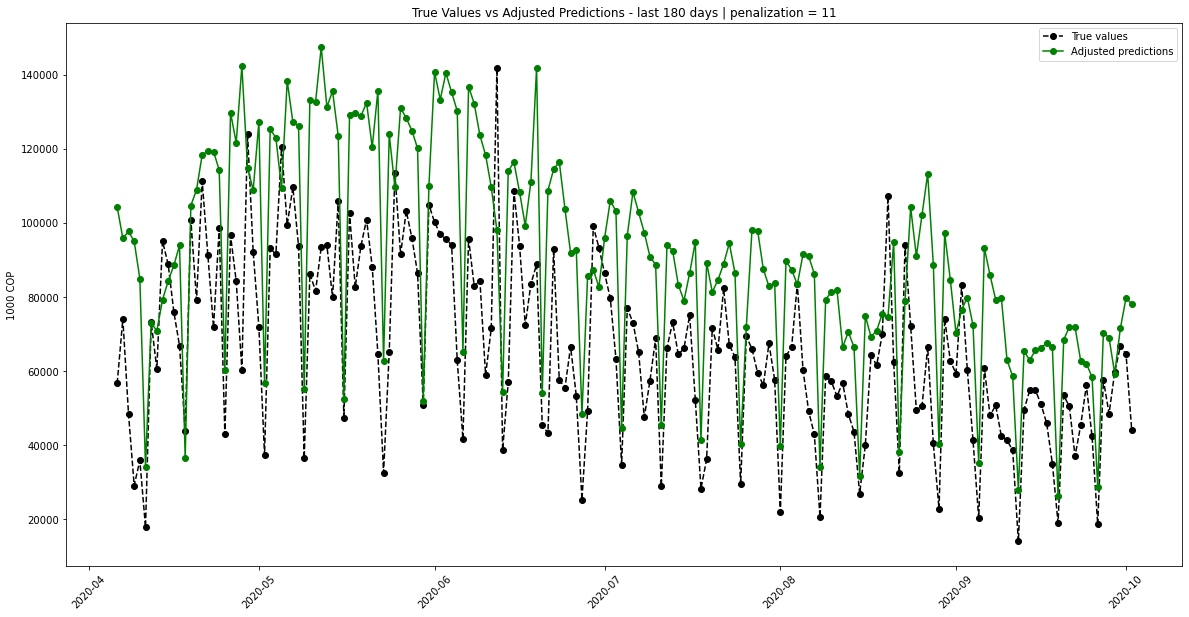

In [61]:
list_results = fun_list_results(y_preds_ens)
metric,penalization = fun_metric(list_results,penalization=11)
y_preds_adj = adj_preds(metric)
plots(y_preds_adj,180,penalization)